In [135]:
import squidpy as sq
import scanpy as sc
import scipy as scp
import numpy as np 
import pandas as pd
import matplotlib.pyplot as pl
import scanorama
from pathlib import Path
import sklearn

In [102]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
OpenGL                      3.1.7
PIL                         9.4.0
PyQt5                       NA
annoy                       NA
appdirs                     1.4.4
appnope                     0.1.3
arrow                       1.2.3
asciitree                   NA
asttokens                   NA
attr                        22.2.0
babel                       2.14.0
backcall                    0.2.0
cachey                      0.2.1
certifi                     2022.12.07
cffi                        1.15.1
charset_normalizer          3.1.0
cloudpickle                 3.0.0
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
dask                        2024.2.1
dask_image                  2023.08.1
datashader                  0.16.0
datatree                    0.0.14
dateutil                    2.8.2
debugpy                     1.6.6
decorator                   5.1.1
defusedxml              

In [103]:
sclcSC = sc.read_h5ad('hlca/sclcSingletwGenes.h5ad')
sclcVisium = sc.read_visium(path='visium/', count_file='sclcVisiumRaw.h5')
sclcVisiumFiltered = sc.read_visium(path='visium/', count_file='sclcVisiumFiltered.h5')

reading visium/sclcVisiumRaw.h5
 (0:00:01)


/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


reading visium/sclcVisiumFiltered.h5
 (0:00:01)


/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/shivaramakrishna/Library/Python/3.9/lib/python/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [120]:
sc.pp.calculate_qc_metrics(sclcVisiumFiltered, inplace=True)

In [121]:
sclcVisiumFiltered.var.index

Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15',
       'AGRN', 'RNF223', 'C1orf159',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=18085)

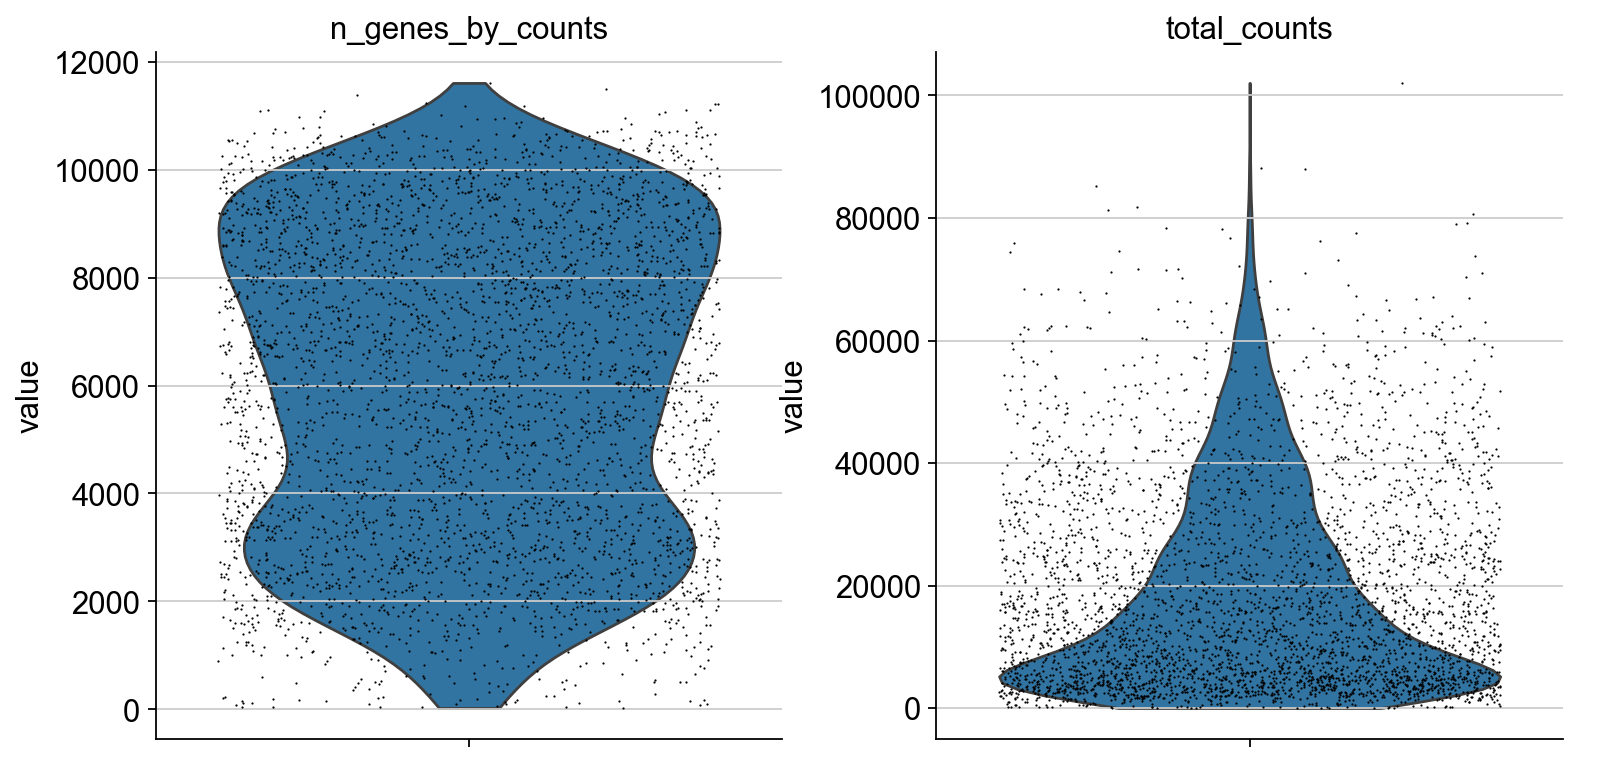

In [122]:
sc.pl.violin(sclcVisiumFiltered, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

In [124]:
integration = scanorama.correct_scanpy([sclcSC,sclcVisiumFiltered], return_dimred=True)

Found 17510 genes among all datasets
[[0.        0.1879212]
 [0.        0.       ]]
Processing datasets (0, 1)


In [133]:
sclcSC.obsm.X_umap

AttributeError: 'AxisArrays' object has no attribute 'X_umap'

In [134]:
sclcData = sc.concat(
    integration,
    label="dataset",
    keys=["single-cell", "spatial"],
    join="outer",
    uns_merge="first",
)

In [136]:
sclcData

AnnData object with n_obs × n_vars = 24419 × 17510
    obs: 'suspension_type', 'donor_id', 'is_primary_data', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'tissue_ontology_term_id', 'organism_ontology_term_id', 'sex_ontology_term_id', "3'_or_5'", 'BMI', 'age_or_mean_of_age_range', 'age_range', 'anatomical_region_ccf_score', 'ann_coarse_for_GWAS_and_modeling', 'ann_finest_level', 'ann_level_1', 'ann_level_2', 'ann_level_3', 'ann_level_4', 'ann_level_5', 'cause_of_death', 'core_or_extension', 'dataset', 'fresh_or_frozen', 'log10_total_counts', 'lung_condition', 'mixed_ancestry', 'original_ann_level_1', 'original_ann_level_2', 'original_ann_level_3', 'original_ann_level_4', 'original_ann_level_5', 'original_ann_nonharmonized', 'reannotation_type', 'sample', 'scanvi_label', 'sequencing_platform', 'smoking_status', 'study', 'subject_type', 'tissue_coarse_unharmonized', 't

In [142]:
from sklearn.metrics.pairwise import cosine_distances

distance = 1 - cosine_distances(
    sclcData[sclcData.obs.dataset == "single-cell"].obsm[
        "X_scanorama"
    ],
    sclcData[sclcData.obs.dataset == "spatial"].obsm[
        "X_scanorama"
    ],
)

In [143]:
def label_transfer(dist, labels):
    '''
    Probability based labels' assignment function
    '''
    lab = pd.get_dummies(labels).to_numpy().T
    class_prob = lab @ dist
    norm = np.linalg.norm(class_prob, 2, axis=0)
    class_prob = class_prob / norm
    class_prob = (class_prob.T - class_prob.min(1)) / class_prob.ptp(1)
    return class_prob

In [144]:
class_prob_sclc = label_transfer(distance, sclcSC.obs.cell_type) # compute labels

In [145]:
cp_sclc_df = pd.DataFrame(
    class_prob_sclc,
    columns=sorted(sclcSC.obs["cell_type"].cat.categories),
)

cp_sclc_df.index = sclcVisiumFiltered.obs.index  # transfer index

In [149]:
sclc_transfer = sclcVisiumFiltered.copy()
sclc_transfer.obs = pd.concat(
    [sclcVisiumFiltered.obs, cp_sclc_df], axis=1
)

In [173]:
sclc_transfer.var_names

Index(['SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1', 'HES4', 'ISG15',
       'AGRN', 'RNF223', 'C1orf159',
       ...
       'MT-ND2', 'MT-CO2', 'MT-ATP6', 'MT-CO3', 'MT-ND3', 'MT-ND4L', 'MT-ND4',
       'MT-ND5', 'MT-ND6', 'MT-CYB'],
      dtype='object', length=18085)

TypeError: can't multiply sequence by non-int of type 'float'

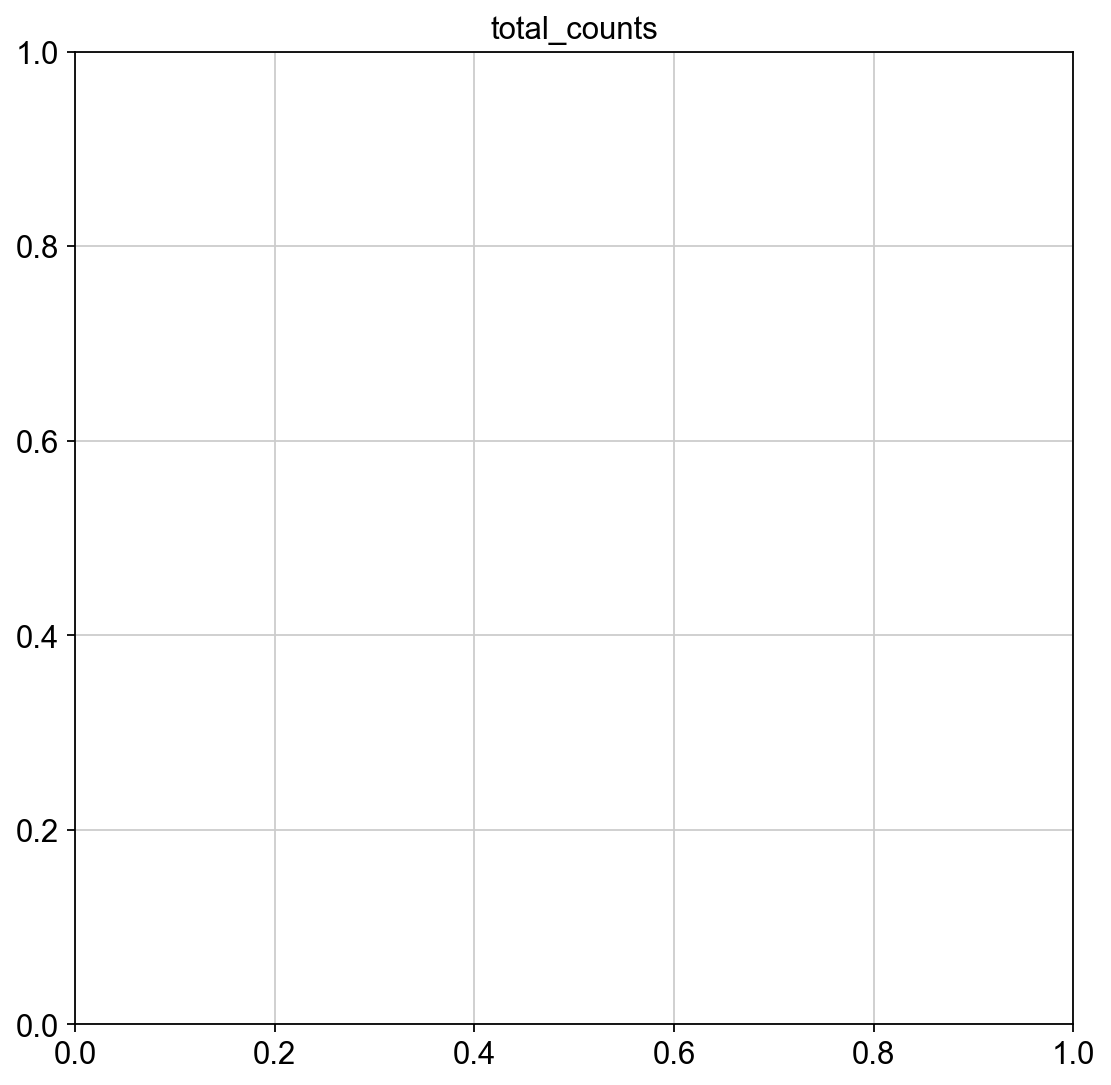

In [174]:
sc.pl.spatial(
    sclc_transfer,
    # img_key="hires",
    color=["total_counts"],
    size=1.5,
)